In [1]:
import pandas as pd

In [2]:

df = pd.read_csv('our-bma.csv')


In [3]:
df


,Refs,Reads
0,ACCATAATGCGTGGGGCCGACCTCGGAATGCGGTCTCCATGCGCGT...,ACCATAATGCGTGGGGCCGACCTCGGAATGCGGTCTCCATGCGCGT...
1,TCGAAGCAGTAGGGCCTACCAAATAGGTTGGTCCTCCGTTGTATCT...,TCGAAGCAGTAGGGCCTACCAAATAGGTTGGTCCTCCGTTGTATCT...
2,AGTTAACGTCCCACGGCGAGGCACTCTTGATCCCCACCTTCAAGAG...,AGTTAACGTCCCACGGCGAGGCACTCTTGATCCCCACCTTCAAGAG...
3,GCCCAAGGGTACGCCCGCAGCGACGCAATTGGCGGAGTAAGCGCGT...,GCCCAAGGGTACGCCCGCAGCGACGCAATTGGCGGAGTAAGCGCGT...
4,GCACTGATGTAACTCATGGTACATCCGTCGCTGAGCGCCATTTTGT...,GCACTGATGTAACTCATGGTACATCCGTCGCTGAGCGCCATTTTGT...
...,...,...
9995,GCATGATTTGGAAGGTCGGCACTATACCCACCCAGGGTATATGGTC...,GCATGATTTGGAAGGTCGGCACTATACCCACCCAGGGTATATGGTC...
9996,GAAGTTTGGAACGTGTTCGTCCGCCAATTAAGGTTGGCTTCTAGTA...,GAAGTTTGGAACGTGTTCGTCCGCCAATTAAGGTTGGCTTCTAGTA...
9997,TGCATCCCGGACAACCGCAAGGGTGCATGGGCACCGCAATTCCCAA...,TGCATCCCGGACAACCGCAAGGGTGCATGGGCACCGCAATTCCCAA...
9998,ACTGGACGTCCTATGCTGGCATAATGAAACGACAACCTGTCTTCGA...,ACTGGACGTCCTATGCTGGCATAATGAAACGACAACCTGTCTTCGA...


In [4]:
from tqdm import tqdm


In [5]:
noisy_strands = [s.strip() for s in list(df['Reads'])]


In [6]:
ref_strands = [s.strip() for s in list(df['Refs'])]


In [7]:
import difflib


In [8]:
import matplotlib.pyplot as plt
import numpy as np
import os

# use LaTeX fonts in the plot
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2021basic/bin/universal-darwin'

In [9]:
def print_diff(ref_strand, noisy_strand):
    global pairs
    global pairs_no_pos
    a, b = 0, 0

    # quadratic time, no heuristics
    for match in difflib.SequenceMatcher(None, ref_strand, noisy_strand, autojunk=False).get_matching_blocks():
        was = ref_strand[a:match.a]
        now = noisy_strand[b:match.b]
        
        a = match.a + match.size
        b = match.b + match.size
        
        if was == '' and now == '':
            pass
        else:
            # print('{}|{}'.format(was, now), end=', ')
            pairs += [(was, now, match.a)]
            pairs_no_pos += [(was, now)]



100%|██████████| 10000/10000 [00:00<00:00, 100522.56it/s]


[0, 9, 39, 38, 40, 40, 34, 35, 39, 34, 39, 46, 41, 46, 49, 46, 52, 56, 61, 55, 69, 64, 71, 66, 68, 69, 66, 73, 76, 76, 71, 81, 71, 75, 77, 80, 83, 84, 84, 83, 87, 82, 94, 94, 103, 98, 94, 94, 96, 103, 97, 105, 99, 90, 680, 675, 668, 697, 646, 659, 673, 689, 660, 693, 673, 677, 672, 640, 671, 658, 652, 647, 650, 649, 643, 657, 629, 647, 651, 645, 622, 647, 651, 635, 642, 626, 602, 638, 644, 622, 632, 643, 625, 631, 640, 610, 604, 642, 628, 635, 625, 651, 625, 626, 585, 592, 582, 620, 367, 777]


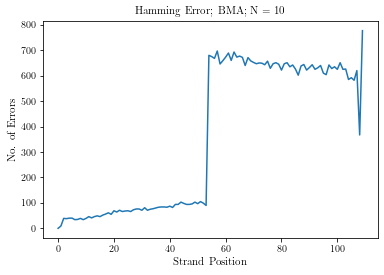

In [10]:
# Hamming Distance Graph
strand_len = 110
count_pos = [0] * (strand_len + 1)

def hamming(ref_strand, recons_strand):
    for i, (c1, c2) in enumerate(zip(ref_strand, recons_strand)):
        if c1 != c2:
            count_pos[i] += 1

for i in tqdm(range(len(ref_strands))):
    hamming(ref_strands[i], noisy_strands[i])

print(count_pos[:-1])
f = plt.figure()
plt.plot(range(strand_len), count_pos[:-1])
plt.title(r'Hamming Error; BMA; N = 10', fontsize=11)
plt.xlabel(r'Strand Position', fontsize=11)
plt.ylabel(r'No. of Errors', fontsize=11)
plt.show()
f.savefig('cov10-our-bma-hamming.pdf', bbox_inches='tight')

In [11]:
pairs = []
pairs_no_pos = []

for i in tqdm(range(len(ref_strands))):
    if ref_strands[i] != noisy_strands[i]:
        print_diff(ref_strands[i], noisy_strands[i])


100%|██████████| 10000/10000 [00:01<00:00, 6910.31it/s]


In [12]:

subs_no_pos, counts_no_pos = np.unique(pairs_no_pos, return_counts=True, axis=0)
sorting = np.argsort(counts_no_pos)
subs_no_pos = subs_no_pos[sorting]
counts_no_pos = counts_no_pos[sorting]

for sub, count in zip(subs_no_pos, counts_no_pos):
    if count > 5:
        print("{} -> {}".format(sub[0], sub[1]), count)


C -> GG 6
 -> TC 6
G -> TT 7
 -> GG 9
 -> TT 10
G -> C 18
T -> C 19
T -> A 25
G -> A 28
T -> G 28
A -> C 30
C -> A 72
T ->  73
C -> G 85
G -> T 91
A -> T 99
A -> G 106
C -> T 114
 -> C 227
 -> G 259
 -> T 266
 -> A 270
C ->  318
G ->  327
A ->  408


G -> TT @ 110 6
 -> A @ 110 6
A ->  @ 104 6
A ->  @ 54 6
 -> A @ 51 7
 -> C @ 51 7
 -> C @ 56 7
C -> T @ 108 8
C ->  @ 105 8
C -> A @ 108 8
C -> G @ 107 8
 -> G @ 55 8
 -> T @ 51 9
C -> T @ 109 9
 -> T @ 110 9
C ->  @ 104 9
 -> G @ 51 10
C -> G @ 108 10
A ->  @ 106 10
G ->  @ 109 10
 -> A @ 55 11
A ->  @ 107 11
G ->  @ 108 11
T -> C @ 110 13
C ->  @ 106 13
 -> G @ 110 13
 -> T @ 55 13
 -> C @ 55 14
G -> C @ 110 14
 -> A @ 56 14
 -> T @ 56 15
T -> G @ 110 18
T -> A @ 110 20
T ->  @ 110 20
C ->  @ 107 22
A -> C @ 110 25
G -> A @ 110 25
C -> A @ 110 26
A ->  @ 108 29
 -> C @ 52 30
A ->  @ 109 31
 -> T @ 52 33
C -> G @ 110 34
 -> G @ 52 35
C ->  @ 108 38
 -> A @ 52 42
 -> T @ 54 52
 -> C @ 54 53
C ->  @ 109 53
 -> G @ 54 54
C -> T @ 110 54
G -> T @ 110 55
A -> T @ 110 55
 -> A @ 54 60
A -> G @ 110 66
C ->  @ 110 68
 -> C @ 53 95
 -> T @ 53 105
 -> G @ 53 105
 -> A @ 53 111
G ->  @ 110 246
A ->  @ 110 260
[10, 14, 5, 19, 14, 7, 8, 7, 6, 7, 4, 6, 3, 5, 5, 8, 2, 6, 5, 9, 4, 10, 6, 3, 4, 4, 1,

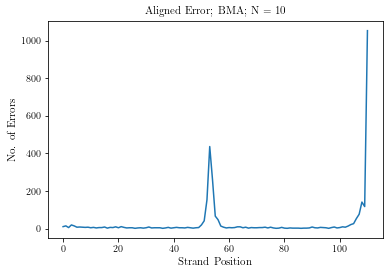

In [13]:
subs, counts = np.unique(pairs, return_counts=True, axis=0)
sorting = np.argsort(counts)
subs = subs[sorting]
counts = counts[sorting]

for sub, count in zip(subs, counts):
    if count > 5:
        print("{} -> {} @ {}".format(sub[0], sub[1], sub[2]), count)

strand_len = 110
pos_counts = [0] * (strand_len + 1)
for sub, count in zip(subs, counts):
    pos_counts[int(sub[2])] += count

print(pos_counts)

f = plt.figure()
plt.plot(range(strand_len + 1), pos_counts)
plt.title(r'Aligned Error; BMA; N = 10', fontsize=11)
plt.xlabel(r'Strand Position', fontsize=11)
plt.ylabel(r'No. of Errors', fontsize=11)
plt.show()
f.savefig('cov10-our-bma-aligned.pdf', bbox_inches='tight')

In [14]:
subs, counts = np.unique(pairs, return_counts=True, axis=0)
sorting = np.argsort(counts)
subs = subs[sorting]
counts = counts[sorting]


In [15]:
def get_key(char1, char2):
    char1 = char1 if char1 != '' else '_'
    char2 = char2 if char2 != '' else '_'
    return char1 + ' -> ' + char2

strand_len = 110
pos_map = {}
pos_counts = [0] * (strand_len + 1)
for sub, count in zip(subs, counts):
    key = get_key(sub[0], sub[1])
    if key not in pos_map:
        pos_map[key] = [0] * (strand_len + 1)
    pos_map[key][int(sub[2])] += count

In [16]:
sub_keys = [get_key(sub[0], sub[1]) for sub in subs_no_pos]
max_10_keys = sub_keys[-10:]
max_10_counts = counts_no_pos[-10:]


[0, 0, 0, 0, 1, 2, 1, 3, 1, 2, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 6, 2, 1, 1, 0, 0, 3, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 2, 0, 2, 1, 1, 0, 6, 1, 10, 11, 29, 31, 260]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 2, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 5, 3, 1, 0, 1, 0, 0, 3, 0, 1, 0, 3, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 2, 1, 0, 1, 1, 0, 2, 4, 3, 11, 10, 246]
[0, 0, 1, 4, 3, 0, 2, 1, 0, 1, 0, 1, 2, 1, 2, 1, 0, 0, 1, 2, 1, 2, 2, 0, 1, 0, 0, 0, 0, 1, 3, 0, 0, 1, 0, 2, 0, 0, 1, 1, 1, 2, 0, 1, 1, 1, 1, 1, 0, 1, 2, 1, 1, 5, 4, 5, 0, 1, 1, 1, 0, 0, 2, 1, 3, 0, 1, 0, 2, 1, 0, 2, 2, 2, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 2, 1, 0, 1, 2, 0, 1, 2, 1, 1, 0, 2, 2, 4, 9, 8, 13,

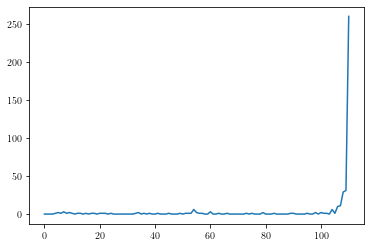

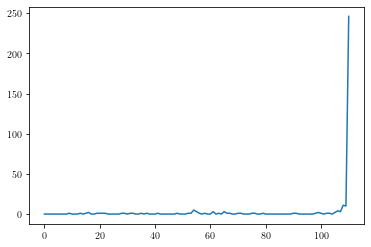

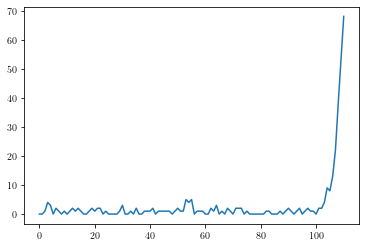

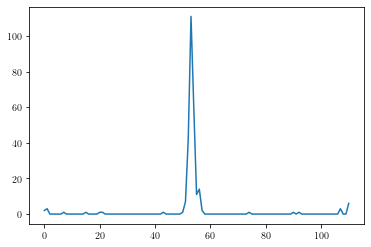

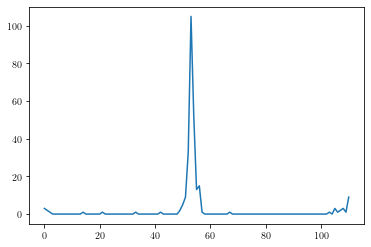

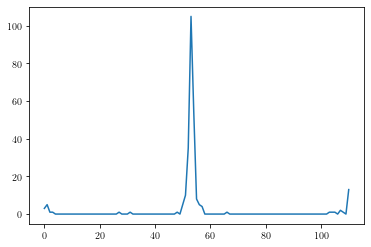

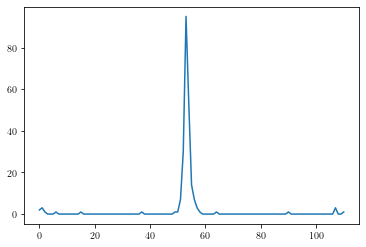

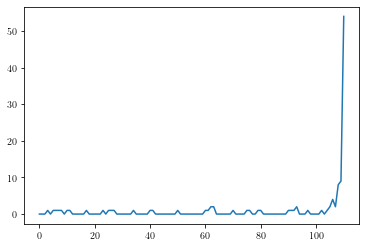

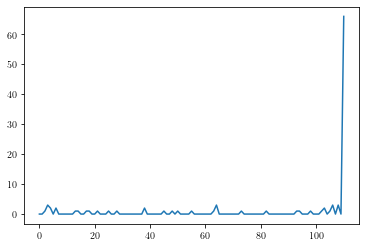

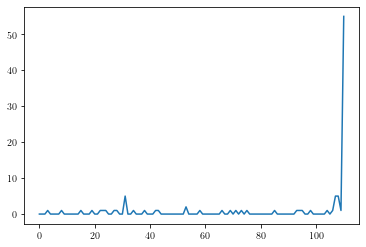

In [17]:
for key, count in zip(reversed(max_10_keys), reversed(max_10_counts)):
    plt.figure(key)
    print(pos_map[key])
    plt.plot(range(strand_len + 1), pos_map[key])

In [18]:
np.save('subs.npy', subs)
np.save('counts.npy', counts)